# Predictions on different data quality

## Parameters and model

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationSource
from predictions.model import PredictionModel

company_name = "Adobe"
time_series_start = "2017-01-03"
time_series_values = 300
column = SeriesColumn.CLOSE
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                           weights={SeriesColumn.OPEN: 0.2,
                                    SeriesColumn.CLOSE: 0.2,
                                    SeriesColumn.ADJ_CLOSE: 0.25,
                                    SeriesColumn.HIGH: 0.15,
                                    SeriesColumn.LOW: 0.15,
                                    SeriesColumn.VOLUME: 0.05})

## Data - one price column

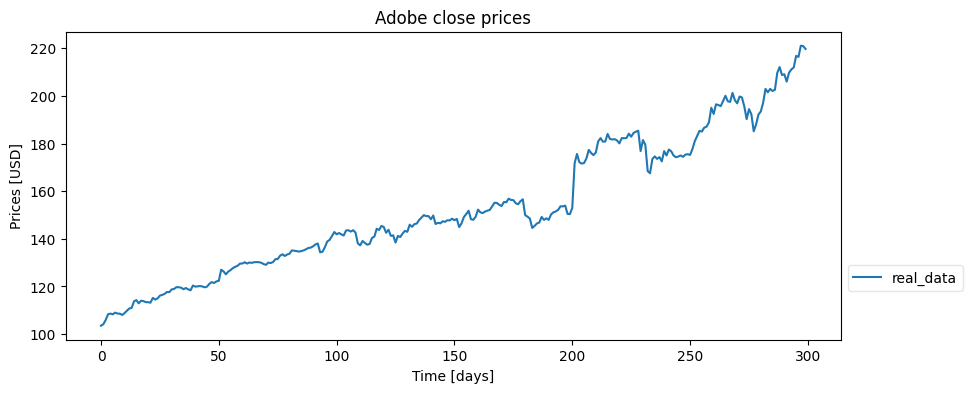

In [2]:
stock.plot_series("close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

## Predictions parameters

In [3]:
prediction_start = 250
iterations = 3

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [4]:
from arima import ManualArima

arima_type = ManualArima

## AR(5)

In [5]:
arima = model.configure_model(arima_type, p=5, q=0)

C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\predictio

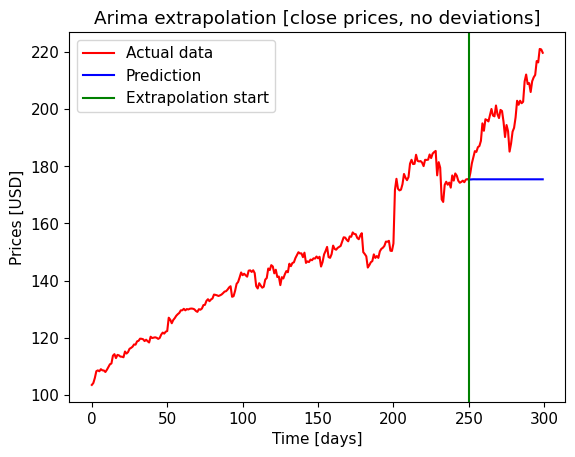

In [6]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [7]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Adobe stock, close price, 3 iterations]

   Deviation Scale Mitigation Time [ms] Time SD   RMSE    MAE   MAPE MAPE SD
0          -     -          N    1556.8   33.59  25.62  23.14  11.38     0.0
1          N     S          N   1602.92   54.82  26.21  23.78  11.71     0.0
2          N     S          Y   2972.81   21.27  21.18  18.48   9.05     0.0
3          N     M          N   1683.43   44.76  25.95   23.5  11.56     0.0
4          N     M          Y    2799.2  104.91  20.69  17.96   8.79     0.0
5          N     H          N   1768.14   20.02   26.2  23.77   11.7     0.0
6          N     H          Y   2001.86   36.51  22.73  20.14   9.88     0.0
7          I     S          N    1439.8   50.75  25.54  23.06  11.34     0.0
8          I     S          Y   1470.25   24.58  25.57   23.1  11.36     0.0
9          I     M          N   1552.71  101.39  25.62  23.15  11.38     0.0
10         I     M          Y   1510.09    4.64  25.65  23.18   11.4     0.0
11         I     H     

## ARIMA(5,1,5)

In [8]:
arima = model.configure_model(arima_type, p=5, q=2)

C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\predictio

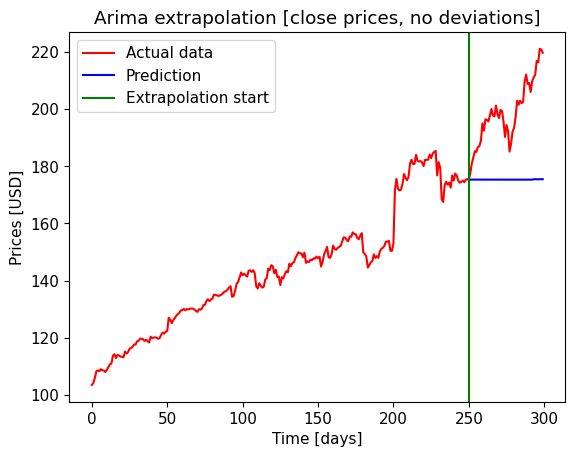

In [9]:
%%capture --no-stdout --no-display
arima.plot_prediction(source=DeviationSource.NONE)

In [10]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Adobe stock, close price, 3 iterations]

   Deviation Scale Mitigation Time [ms] Time SD     RMSE    MAE    MAPE  \
0          -     -          N   6678.71    9.85    25.69  23.23   11.43   
1          N     S          N   9594.52   37.63    26.42  24.01   11.82   
2          N     S          Y  11558.85  320.15    20.71  17.98     8.8   
3          N     M          N  11703.98  345.64    19.65  17.81    8.77   
4          N     M          Y  11418.85  229.49  1113.16  429.4  198.55   
5          N     H          N  10935.28  210.59    26.22  23.77    11.7   
6          N     H          Y   6220.88   169.0    23.14  20.54   10.08   
7          I     S          N  10980.02  253.58    25.68   23.2   11.41   
8          I     S          Y   6990.02   54.97    25.67   23.2   11.41   
9          I     M          N   5382.68     5.7    25.67   23.2   11.41   
10         I     M          Y   9724.72   15.31    25.86   23.4   11.51   
11         I     H          N    9140.5   52.24

## XGBoost

In [11]:
from ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\predictio

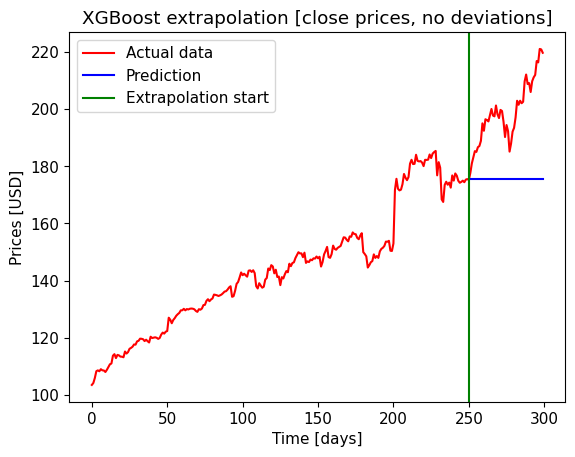

In [12]:
xgboost.plot_prediction(source=DeviationSource.NONE)

In [13]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Adobe stock, close price, 3 iterations]

   Deviation Scale Mitigation Time [ms] Time SD   RMSE    MAE   MAPE MAPE SD
0          -     -          N     88.92    9.02  25.54  23.06  11.34     0.0
1          N     S          N     56.08    5.88  26.28  23.87  11.75     0.0
2          N     S          Y     52.21    9.24  24.34  21.78   10.7     0.0
3          N     M          N     57.37    8.77  25.83  23.37   11.5     0.0
4          N     M          Y     52.33    9.13  24.19  21.61  10.61     0.0
5          N     H          N      47.0    0.22  26.97  24.62  12.13     0.0
6          N     H          Y      62.8    7.97  24.72  22.18   10.9     0.0
7          I     S          N     52.33     8.8  25.54  23.06  11.34     0.0
8          I     S          Y     57.54    8.91  25.54  23.06  11.34     0.0
9          I     M          N     52.31    6.29  25.54  23.06  11.34     0.0
10         I     M          Y     53.67    7.93  25.54  23.06  11.34     0.0
11         I     H     

## Reservoir computing

In [14]:
from predictions.ml import Reservoir

reservoir = model.configure_model(Reservoir)

C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\prediction.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data_to_learn_and_validate = self.data_to_learn.append(self.data_to_validate)
C:\Users\Maciek\Desktop\Magisterka\project\predictions\..\predictions\predictio

In [15]:
reservoir.plot_prediction(source=DeviationSource.NONE)

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 24).

In [ ]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()